In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torchsummary import summary

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist

In [3]:
# create dataloader
batch_size = 128

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

# get device to train on
device = get_device()

Time is 0.02811741828918457 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


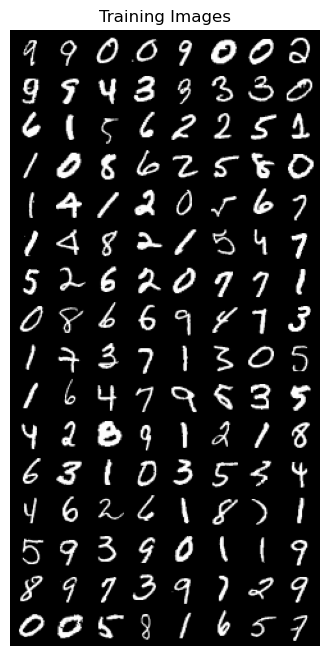

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [11]:
latent_dim = 100
training_params = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=5, beta_1=0.5, batch_size=batch_size)
test_noise = get_noise(25, latent_dim)

## First I train a Wasserstein GAN

In [6]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist().apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein)

In [7]:
summary(trainer_wgan.discriminator.to(device) , (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [9]:
summary(trainer_wgan.generator.to(device), (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [10]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, noise_dim=latent_dim)

Epoch 0 start training...
Epoch: 0/1 Total Steps:469poch_Run_Time: 1424.369176	Loss_C : -358.087646	Loss_G : 30.262564	
Total_Time : 1424.369176
Loss_C : -358.087646
Loss_G : 30.262564
Loss_C_Mean : -142.837894
Loss_G_Mean : 16.960232

----------------------------------------------



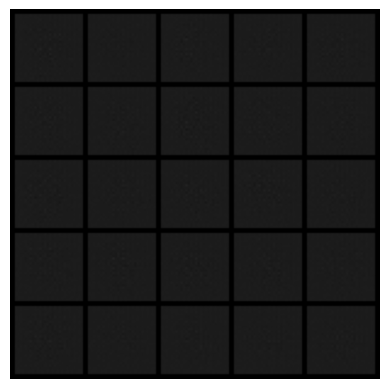

In [14]:
# show generated images
generated_images_wasserstein = (trained_wgan.generator(test_noise))
plot_tensor_images(generated_images_wasserstein, num_images=25)

In [15]:
generated_images_wasserstein

tensor([[[[0.1106, 0.1077, 0.1102,  ..., 0.1081, 0.1101, 0.1084],
          [0.1101, 0.1093, 0.1109,  ..., 0.1095, 0.1111, 0.1086],
          [0.1073, 0.1088, 0.1101,  ..., 0.1086, 0.1124, 0.1086],
          ...,
          [0.1095, 0.1098, 0.1081,  ..., 0.1078, 0.1090, 0.1104],
          [0.1087, 0.1109, 0.1103,  ..., 0.1101, 0.1101, 0.1081],
          [0.1085, 0.1100, 0.1100,  ..., 0.1095, 0.1085, 0.1107]]],


        [[[0.1096, 0.1082, 0.1107,  ..., 0.1082, 0.1101, 0.1088],
          [0.1103, 0.1093, 0.1101,  ..., 0.1098, 0.1100, 0.1090],
          [0.1084, 0.1086, 0.1097,  ..., 0.1072, 0.1113, 0.1090],
          ...,
          [0.1097, 0.1103, 0.1074,  ..., 0.1088, 0.1106, 0.1104],
          [0.1084, 0.1105, 0.1099,  ..., 0.1093, 0.1103, 0.1090],
          [0.1083, 0.1101, 0.1104,  ..., 0.1102, 0.1093, 0.1094]]],


        [[[0.1097, 0.1086, 0.1105,  ..., 0.1071, 0.1094, 0.1082],
          [0.1098, 0.1095, 0.1092,  ..., 0.1098, 0.1105, 0.1084],
          [0.1082, 0.1079, 0.1098,  ..

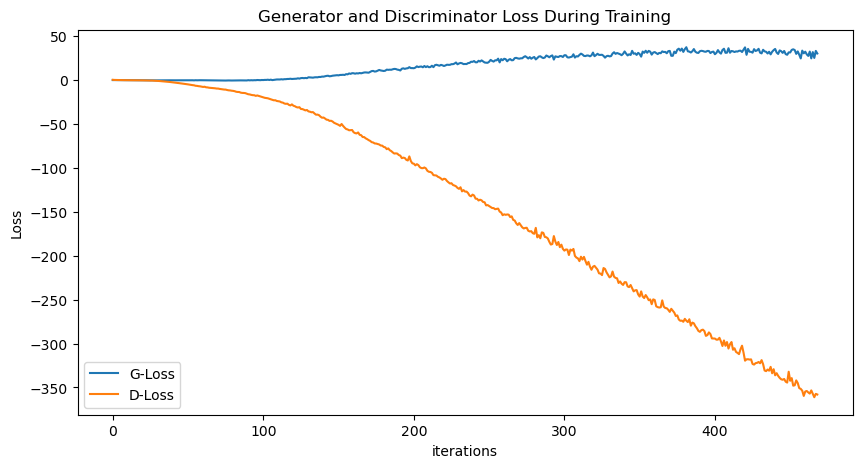

In [13]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

## BHS Gan

In [33]:
training_params_bhs = TrainingParams(lr_dis=0.0001, lr_gen=0.001, num_epochs=1, num_dis_updates=1, num_gen_updates=5, beta_1=0.5, batch_size=batch_size)
generator_bhs = GeneratorBhsMnist(latent_dim)#.apply(init_weights)
discriminator_bhs = DiscriminatorBhsMnist()#.apply(init_weights)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs)

In [34]:
# training loop
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, noise_dim=latent_dim)

Epoch 0 start training...
Epoch: 0/1 Total Steps:469poch_Run_Time: 887.485229	Loss_C : 1.342609	Loss_G : -1.343354		
Total_Time : 887.485229
Loss_C : 1.342609
Loss_G : -1.343354
Loss_C_Mean : 7.299089
Loss_G_Mean : -6.621719

----------------------------------------------



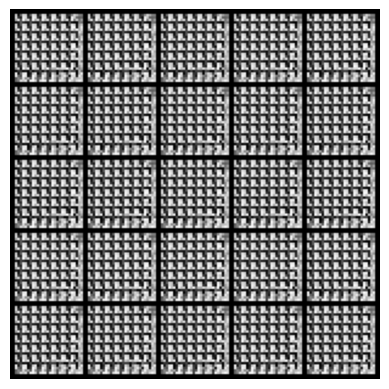

In [35]:
# show generated images
generated_images_bhs = (trained_bhsgan.generator(test_noise))
plot_tensor_images(generated_images_bhs, num_images=25)

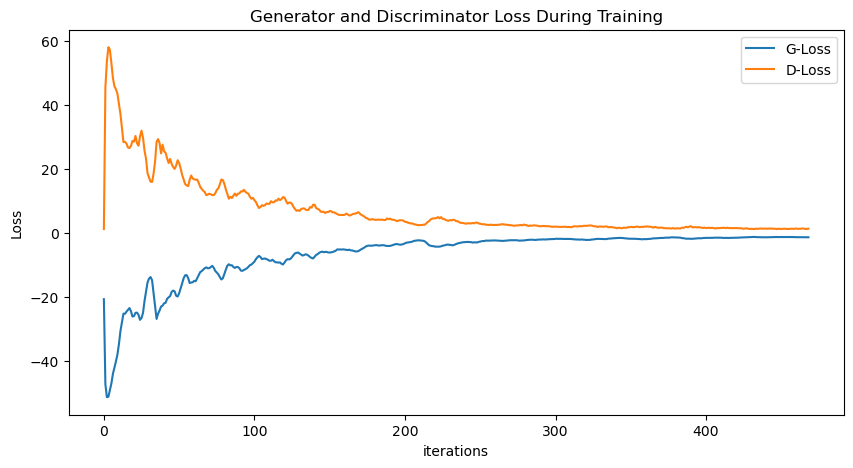

In [36]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## IPM BHS GAN

In [38]:
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist().apply(init_weights)
trainer_ipm = Trainer(training_params, generator_ipm, discriminator_ipm)

In [39]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, noise_dim=latent_dim)

Epoch 0 start training...


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


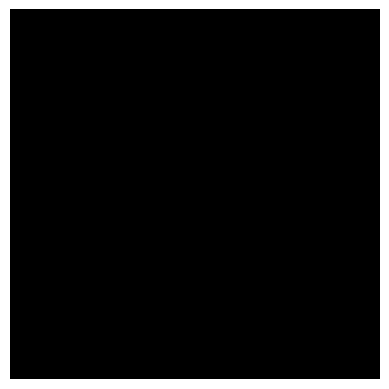

In [36]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

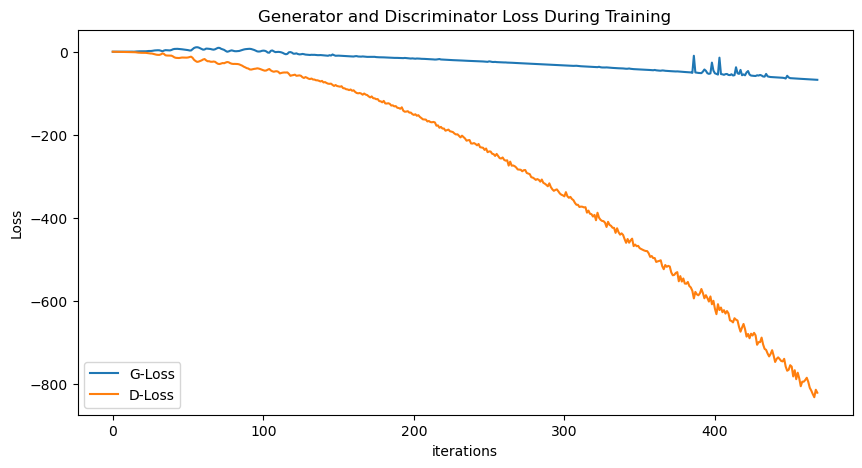

In [37]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)